In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from functools import partial
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]","train[10%:25%]","train[25%:]"],
    as_supervised=True,
    with_info=True)

In [5]:
class_names=info.features["label"].names
n_classes=info.features["label"].num_classes
dataset_size=info.splits["train"].num_examples

In [6]:
def preprocess(image, label):
    resized_image=tf.image.resize(image, [224,224])
    return resized_image, label

In [7]:
batch_size=32
train_set=train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


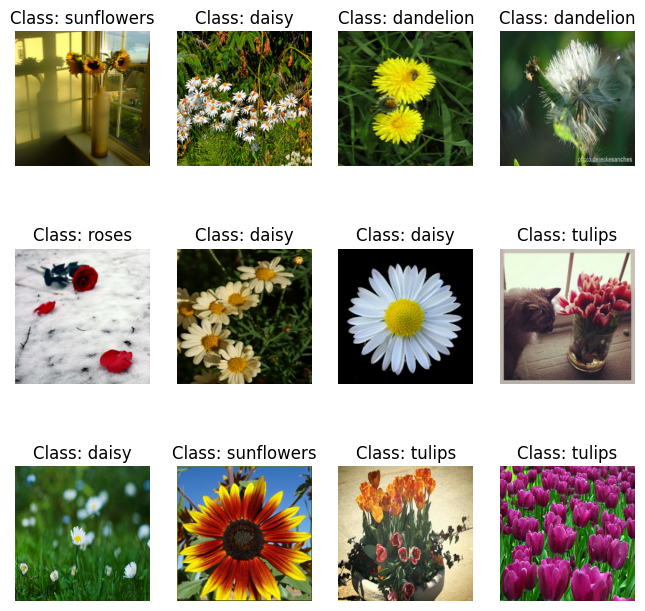

In [8]:
plt.figure(figsize=(8,8))
sample_batch = train_set.take(1)
print(sample_batch)


for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3,4,index+1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [9]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5, activation='relu', padding="SAME")

In [10]:
model = keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    DefaultConv2D(filters=32, kernel_size=7,input_shape=[224, 224, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64, kernel_size=5),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128, kernel_size=3),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D(pool_size=2), 
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=5, activation='softmax'),])

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.fit(train_set, batch_size=32, epochs=10)

Epoch 1/10
16/86 [====>.........................] - ETA: 4:32 - loss: 1.6194 - accuracy: 0.1914

In [24]:

model.evaluate(test_set)

12/12 [==============================] - 6s 347ms/step - loss: 5.1642 - accuracy: 0.1553


[5.164225101470947, 0.15531335771083832]

In [22]:
def preprocess(image, label):
    resized_image=tf.image.resize(image, [224,224])
    final_image=tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label 

In [41]:
batch_size=32
train_set=train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

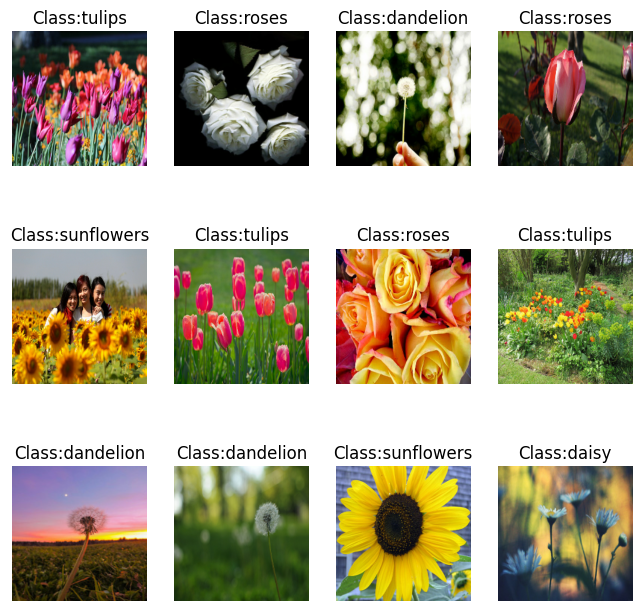

In [42]:
plt.figure(figsize=(8,8))
sample_batch=train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3,4, index+1)
        plt.imshow(X_batch[index]/2+0.5)
        plt.title("Class:{}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [43]:
train_set = train_set.map(lambda x, y: (normalisation(x), tf.one_hot(y, depth=5)))
valid_set = valid_set.map(lambda x, y: (normalisation(x), tf.one_hot(y, depth=5)))
test_set = test_set.map(lambda x, y: (normalisation(x), tf.one_hot(y, depth=5)))

In [44]:
base_model=tf.keras.applications.xception.Xception(weights="imagenet",include_top=False)

In [45]:
tf.keras.utils.plot_model(base_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
padding="SAME", use_bias=False)

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)

# Wyjście z modelu bazowego
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Warstwa wyjściowa
num_classes = 5  # Liczba klas w twoim zbiorze danych
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(global_average_layer)

# Utworzenie modelu
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

# Zablokowanie warstw sieci bazowej
for layer in base_model.layers:
    layer.trainable = False

# Kompilacja modelu i trening
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_set, epochs=5, validation_data=valid_set)



Epoch 1/5
86/86 [==============================] - 184s 2s/step - loss: 1.5546 - accuracy: 0.3230 - val_loss: 1.5010 - val_accuracy: 0.4138
Epoch 2/5
70/86 [=======================>......] - ETA: 30s - loss: 1.4861 - accuracy: 0.3558

KeyboardInterrupt: 